Jupyter Notebook for Us Political Book Network with Traditional AE and Kmeans and Cmeans

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz
from copy import deepcopy
import json
import numpy as np
from scipy.linalg import fractional_matrix_power
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import os

/Users/ashfak/venv-metal/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Import Dolphin Network and feature matrix creation

Kmeans++ with Traditional Auto Encoder

In [2]:
# Create the graph (example using networkx)
G = nx.read_gml('polbooks.gml')  # Load the Dolphin network if available or replace with appropriate graph loading method
node_names = np.array(list(G.nodes()))
print(node_names)
# Adjacency matrix
A = nx.adjacency_matrix(G).toarray()

# Adding self-loops
A = A + np.eye(G.number_of_nodes())

# Degree matrix
D = np.diag(np.sum(A, axis=1))

# Compute D^-0.5
D_half_norm = fractional_matrix_power(D, -0.5)

# Feature matrix initialization (simple identity matrix in this example)
E = np.eye(G.number_of_nodes())
C = np.eye(G.number_of_nodes())  # This is just a placeholder, replace or modify as per actual features
X = np.concatenate((E, C), axis=1)

# Graph convolution operation
X = D_half_norm.dot(A).dot(D_half_norm).dot(X)

['1000 Years for Revenge' 'Bush vs. the Beltway' "Charlie Wilson's War"
 'Losing Bin Laden' 'Sleeping With the Devil' 'The Man Who Warned America'
 'Why America Slept' 'Ghost Wars' 'A National Party No More'
 'Bush Country' 'Dereliction of Duty' 'Legacy' 'Off with Their Heads'
 'Persecution' "Rumsfeld's War" 'Breakdown' 'Betrayal' 'Shut Up and Sing'
 'Meant To Be' 'The Right Man' 'Ten Minutes from Normal'
 "Hillary's Scheme" 'The French Betrayal of America'
 'Tales from the Left Coast' 'Hating America' 'The Third Terrorist'
 'Endgame' 'Spin Sisters' "All the Shah's Men" 'Dangerous Dimplomacy'
 'The Price of Loyalty' 'House of Bush, House of Saud'
 'The Death of Right and Wrong' 'Useful Idiots' "The O'Reilly Factor"
 'Let Freedom Ring' 'Those Who Trespass' 'Bias' 'Slander'
 'The Savage Nation' 'Deliver Us from Evil' 'Give Me a Break'
 'The Enemy Within' 'The Real America' "Who's Looking Out for You?"
 'The Official Handbook Vast Right Wing Conspiracy' 'Power Plays'
 'Arrogance' 'The Per

Define the variational autoencoder

In [3]:
class AE(keras.Model):
    def __init__(self, encoder, decoder, A, **kwargs):
        super(AE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.A = A
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.architecture_loss_tracker = keras.metrics.Mean(
            name="architecture_loss"
        )

    def call(self, inputs):
      x = self.encoder(inputs)
      x = self.decoder(x)
      return x

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.architecture_loss_tracker
        ]
    def predict(self, data):
       z_mean, z_log_var, z = self.encoder(data)
       output = self.decoder(z)
       return output

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            #reconstruction_loss = tf.reduce_mean(
            #    tf.reduce_sum(
            #        keras.losses.mean_absolute_error(data, reconstruction), axis=(1, 2)
            #    )
            #)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data-reconstruction), axis=(1)))
            architecture_loss = tf.reduce_mean(tf.square(self.A - tf.matmul(z,z,transpose_b=True)))
            total_loss = reconstruction_loss + architecture_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.architecture_loss_tracker.update_state(architecture_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "architecture_loss": self.architecture_loss_tracker.result()
        }

In [4]:
#For AE
nFeatures = X.shape[1]
nEmbeddings = 2
nEpochs = 8000
learningRate = 0.001
optimizer = Adam(learningRate)
batchSize = X.shape[0]


2024-04-22 20:25:41.258669: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-22 20:25:41.258782: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-22 20:25:41.258800: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-22 20:25:41.258884: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-22 20:25:41.258940: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
scaler = StandardScaler()
scaledX = scaler.fit_transform(X)

In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

print(nFeatures)
input_encoder = Input(shape=(nFeatures, ))
nNeurons = nFeatures // 2
x = Dense(nNeurons, activation='tanh')(input_encoder)
nNeurons = nNeurons // 2
while(nNeurons >= nEmbeddings * 2):
  x = Dense(nNeurons, activation='tanh')(x)
  nNeurons = nNeurons // 2
z = Dense(nEmbeddings, name="z")(x)

input_decoder = Input(shape=(nEmbeddings, ))
nNeurons = nEmbeddings * 2
x = Dense(nNeurons, activation='tanh')(input_decoder)
nNeurons = nNeurons * 2
while(nNeurons <= nFeatures // 2):
  x = Dense(nNeurons, activation='tanh')(x)
  nNeurons = nNeurons * 2
recon = Dense(nFeatures)(x)
encoder = Model(input_encoder, z, name="encoder")
decoder = Model(input_decoder, recon, name="decoder")
ae = AE(encoder, decoder, A)
ae.compile(optimizer=optimizer)
ae.built = True

210


In [8]:
hist = ae.fit(X, epochs = nEpochs, batch_size=batchSize, verbose = False)

2024-04-22 20:26:47.297025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [9]:
ae.save_weights(os.getcwd()+'/ae_dolphins' + '.weights.h5')
ae.load_weights(os.getcwd()+'/ae_dolphins' + '.weights.h5')

dict_keys(['architecture_loss', 'reconstruction_loss', 'total_loss'])


Text(0, 0.5, 'Architecture loss')

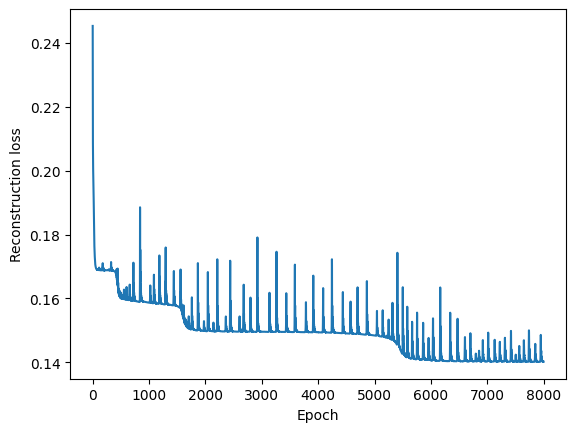

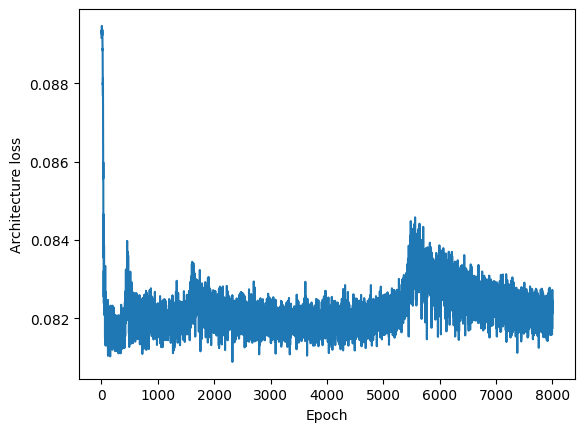

In [10]:
print(hist.history.keys())
x_range = range(len(hist.history['total_loss']))
plt.plot(x_range, hist.history['reconstruction_loss'])
plt.xlabel('Epoch')
plt.ylabel('Reconstruction loss')
plt.figure()
plt.plot(x_range, hist.history['architecture_loss'])
plt.xlabel('Epoch')
plt.ylabel('Architecture loss')

In [11]:
Z = ae.encoder(X)

In [12]:
from sklearn.cluster import KMeans

In [93]:
max_n = 50
lst_SSE = []
lst_labels = []
lst_centroids = []
lst_silhouette_scores = []
for n_cluster in range(2, max_n + 1):
  kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(Z)
  SSE = 0
  for i in range(len(Z)):
    C = np.asarray(kmeans.cluster_centers_[kmeans.labels_[i]])
    loc = np.asarray(Z[i])
    SSE += np.sum(np.square(C - loc))
  lst_SSE.append(SSE)
  lst_labels.append(kmeans.labels_)
  lst_centroids.append(kmeans.cluster_centers_)
  score = silhouette_score(Z, kmeans.labels_)
  lst_silhouette_scores.append(score)

Text(0, 0.5, 'SSE')

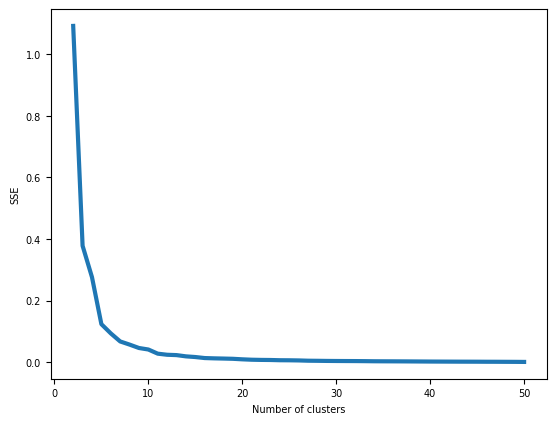

In [94]:
xRange = [i for i in range(2,max_n + 1)]
plt.plot(xRange, lst_SSE)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

Text(0, 0.5, 'Silhouette Score')

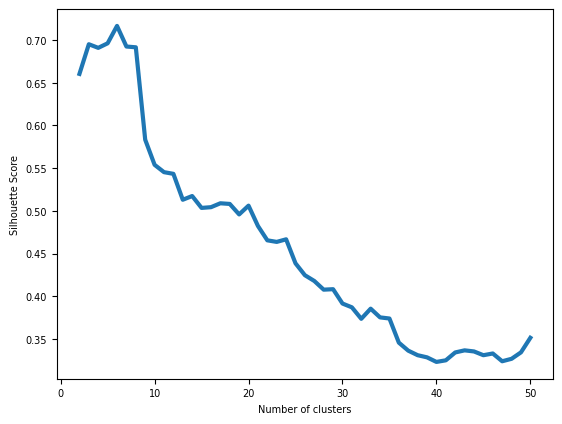

In [95]:
# Silhouette Score
xRange = [i for i in range(2,max_n + 1)]
plt.plot(xRange, lst_silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

In [106]:
n_clusters = 9
inx = n_clusters-2
members = [[] for _ in range(n_clusters)]
members_classes = [[] for _ in range(n_clusters)]
for i in range(len(lst_labels[inx])):
  members[lst_labels[inx][i]].append(i)
  members_classes[lst_labels[inx][i]].append(node_names[i])

In [107]:
file = open(os.getcwd()  + '/list_clusters_polbooks/'+'_'+ str(n_clusters) + '_no_redundancy_ae_kmeans.json','w')
file.write(json.dumps(members_classes))
file.close()

In [108]:
import random

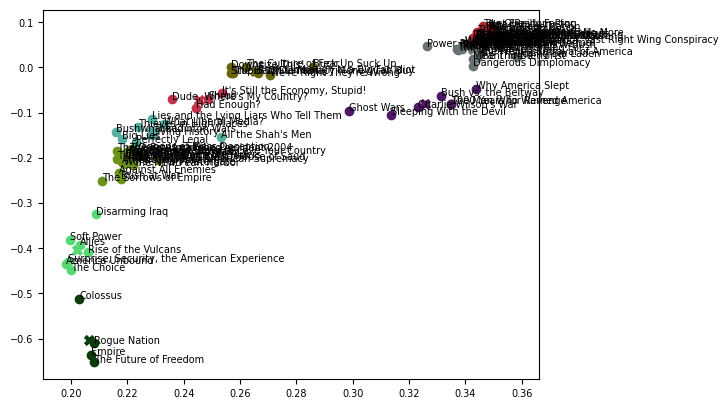

In [109]:
y = [[] for i in range(n_clusters)]
x = [[] for i in range(n_clusters)]
centroid_y = []
centroid_x = []
hexadecimal_alphabets = '0123456789ABCDEF'
colors = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in range(6)]) for i in range(n_clusters)]
# colors = ['red','green','blue','purple','orange', 'black', 'gray', 'pink', 'yellow', 'navy']
for i in range(n_clusters):
  for j in members[i]:
    y[i].append(Z[j][1])
    x[i].append(Z[j][0])
  centroid_y.append(lst_centroids[n_clusters-2][i][1])
  centroid_x.append(lst_centroids[n_clusters-2][i][0])
# plt.axis('off')
plt.rcParams.update({'font.size': 7, 'lines.linewidth':3})
for i in range(n_clusters):
  plt.scatter([centroid_x[i]], [centroid_y[i]], color=colors[i],marker='x')
  plt.scatter(x[i], y[i], color=colors[i])
  for j in range(len(x[i])):
    plt.text(x[i][j], y[i][j], members_classes[i][j])
plt.savefig(os.getcwd() +'/figures_polbooks/'+ '_' + str(n_clusters) + f'_scatter_no_redundancy_vae_kmeans.pdf', dpi=450, bbox_inches = "tight")

In [110]:
from sklearn.metrics import silhouette_score

In [111]:
silhouette_avg = silhouette_score(Z, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.3512945771217346


C means with traditional auto encoder

In [112]:
maxNCenters = 50
losses = []
memberships = []
centroids = []
silhouette_scores = []
for nCenters in range(2,maxNCenters+1):
  cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
          Z.numpy().T, nCenters, 2, error=0.005, maxiter=1000, init=None)
  memberships.append(u)
  centroids.append(cntr)
  sse = 0
  for i in range(len(Z)):
    zLoc = np.asarray(Z[i])
    for j in range(nCenters):
      cLoc = np.asarray(cntr[j])
      sse += u[j][i] * np.sum(np.square(zLoc - cLoc))
  losses.append(sse)
  hard_clusters = np.argmax(u, axis=0)
  silhouette_scores.append(silhouette_score(Z, hard_clusters))

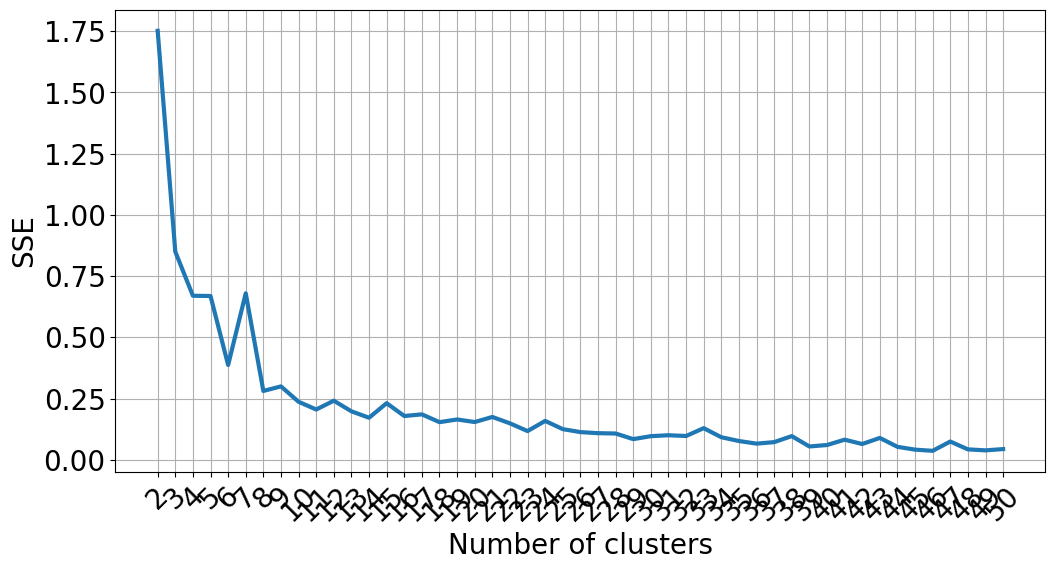

In [113]:
x_range = [i for i in range(2,maxNCenters+1)]
plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 20, 'lines.linewidth':3})
plt.plot(x_range,losses)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.xticks(x_range, rotation=45)
plt.grid(True)

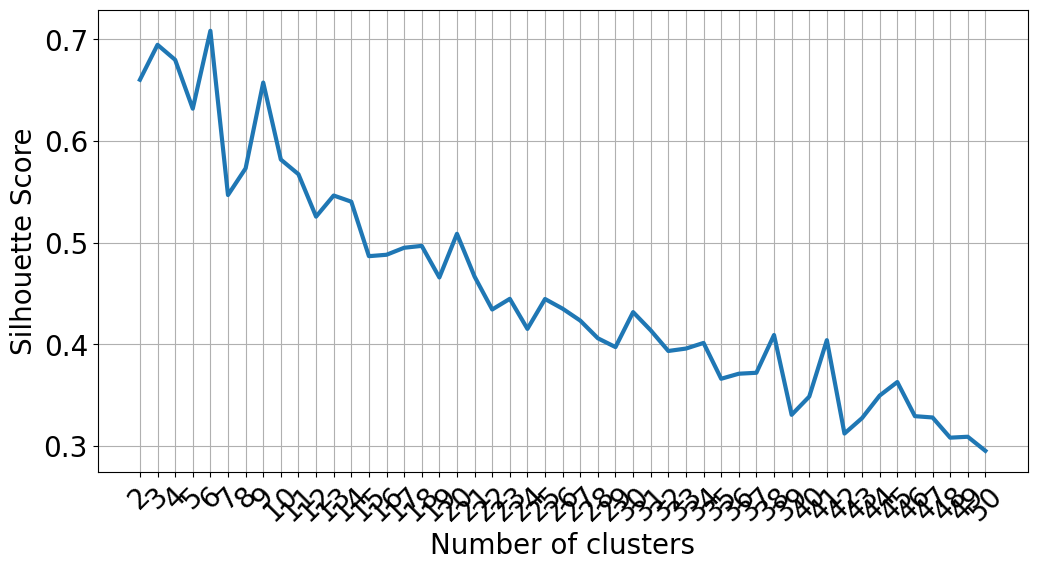

In [114]:
x_range = [i for i in range(2,maxNCenters+1)]
plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 20, 'lines.linewidth':3})
plt.plot(x_range,silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(x_range, rotation=45)
plt.grid(True)

In [115]:
n_clusters = 9
members = [[] for i in range(n_clusters)]
members_classes = [[] for i in range(n_clusters)]
clusters = np.argmax(memberships[n_clusters-2].T, axis = 1)
for i in range(len(clusters)):
  members[clusters[i]].append(i)
  members_classes[clusters[i]].append(node_names[i])

In [116]:
file = open(os.getcwd()  + '/list_clusters_polbooks/'+'_'+ str(n_clusters) + '_no_redundancy_ae_cmeans.json','w')
file.write(json.dumps(members_classes))
file.close()

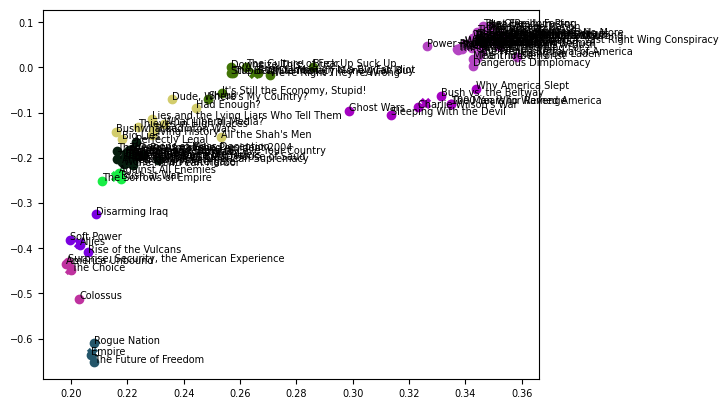

In [117]:
y = [[] for i in range(n_clusters)]
x = [[] for i in range(n_clusters)]
centroid_y = []
centroid_x = []
hexadecimal_alphabets = '0123456789ABCDEF'
colors = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in range(6)]) for i in range(n_clusters)]
# colors = ['red','green','blue','purple','orange', 'black', 'gray', 'pink', 'yellow', 'navy']
for i in range(n_clusters):
  for j in members[i]:
    y[i].append(Z[j][1])
    x[i].append(Z[j][0])
  centroid_y.append(centroids[n_clusters-2][i][1])
  centroid_x.append(centroids[n_clusters-2][i][0])
# plt.axis('off')
plt.rcParams.update({'font.size': 7, 'lines.linewidth':3})
for i in range(n_clusters):
  plt.scatter([centroid_x[i]], [centroid_y[i]], color=colors[i],marker='x')
  plt.scatter(x[i], y[i], color=colors[i])
  for j in range(len(x[i])):
    plt.text(x[i][j], y[i][j], members_classes[i][j])
plt.savefig(os.getcwd() +'/figures_polbooks/'+ '_' + str(n_clusters) + f'_scatter_no_redundancy_vae_kmeans.pdf', dpi=450, bbox_inches = "tight")

In [60]:
from sklearn.metrics import silhouette_score

In [134]:
thresholds = []
i = 0.1
while(i <= 0.5):
  thresholds.append(round(i,2))
  i += 0.05

set_members = []
json_files = []
for threshold in thresholds:
  tmp_members = deepcopy(members)
  tmp_members_classes = deepcopy(members_classes)
  for inx, membership in enumerate(memberships[n_clusters-2]):
    for inx2, score in enumerate(membership):
      if(score >=  threshold):
        if(inx2 not in tmp_members[inx]):
          tmp_members[inx].append(inx2)
          tmp_members_classes[inx].append(node_names[inx2])
  set_members.append(tmp_members_classes)
  file = open(os.getcwd() +'/list_clusters_polbooks/'+ str(n_clusters) + '_redundancy_ae_' + str(threshold) + '.json','w')
  json_files.append(os.getcwd() +'/list_clusters_polbooks/'+ str(n_clusters) + '_redundancy_ae_' + str(threshold) + '.json')
  file.write(json.dumps(tmp_members_classes))
  file.close()

In [136]:
print(json_files)

['/Users/ashfak/Downloads/rerequestforcode/list_clusters_polbooks/9_redundancy_ae_0.1.json', '/Users/ashfak/Downloads/rerequestforcode/list_clusters_polbooks/9_redundancy_ae_0.15.json', '/Users/ashfak/Downloads/rerequestforcode/list_clusters_polbooks/9_redundancy_ae_0.2.json', '/Users/ashfak/Downloads/rerequestforcode/list_clusters_polbooks/9_redundancy_ae_0.25.json', '/Users/ashfak/Downloads/rerequestforcode/list_clusters_polbooks/9_redundancy_ae_0.3.json', '/Users/ashfak/Downloads/rerequestforcode/list_clusters_polbooks/9_redundancy_ae_0.35.json', '/Users/ashfak/Downloads/rerequestforcode/list_clusters_polbooks/9_redundancy_ae_0.4.json', '/Users/ashfak/Downloads/rerequestforcode/list_clusters_polbooks/9_redundancy_ae_0.45.json', '/Users/ashfak/Downloads/rerequestforcode/list_clusters_polbooks/9_redundancy_ae_0.5.json']


In [137]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [139]:
import json
import matplotlib.pyplot as plt
import os

# Define the book to track
book_to_track = "The Price of Loyalty"


# Sort files by extracting the threshold value from the filename
json_files.sort(key=lambda x: float(x.split('_')[-1].replace('.json', '')))

# Initialize data storage
books = set()
book_cluster_mapping = {}

# Collect all books and initialize their tracking dictionaries
for json_file in json_files:
    with open(json_file, 'r') as file:
        clusters = json.load(file)
    for cluster in clusters:
        for book in cluster:
            books.add(book)
            if book not in book_cluster_mapping:
                book_cluster_mapping[book] = []

# Track cluster changes for each book
for json_file in json_files:
    threshold = float(json_file.split('_')[-1].replace('.json', ''))
    with open(json_file, 'r') as file:
        clusters = json.load(file)
    for book in books:
        found = False
        for index, cluster in enumerate(clusters):
            if book in cluster:
                book_cluster_mapping[book].append((threshold, index))
                found = True
                break
        if not found:
            book_cluster_mapping[book].append((threshold, None))


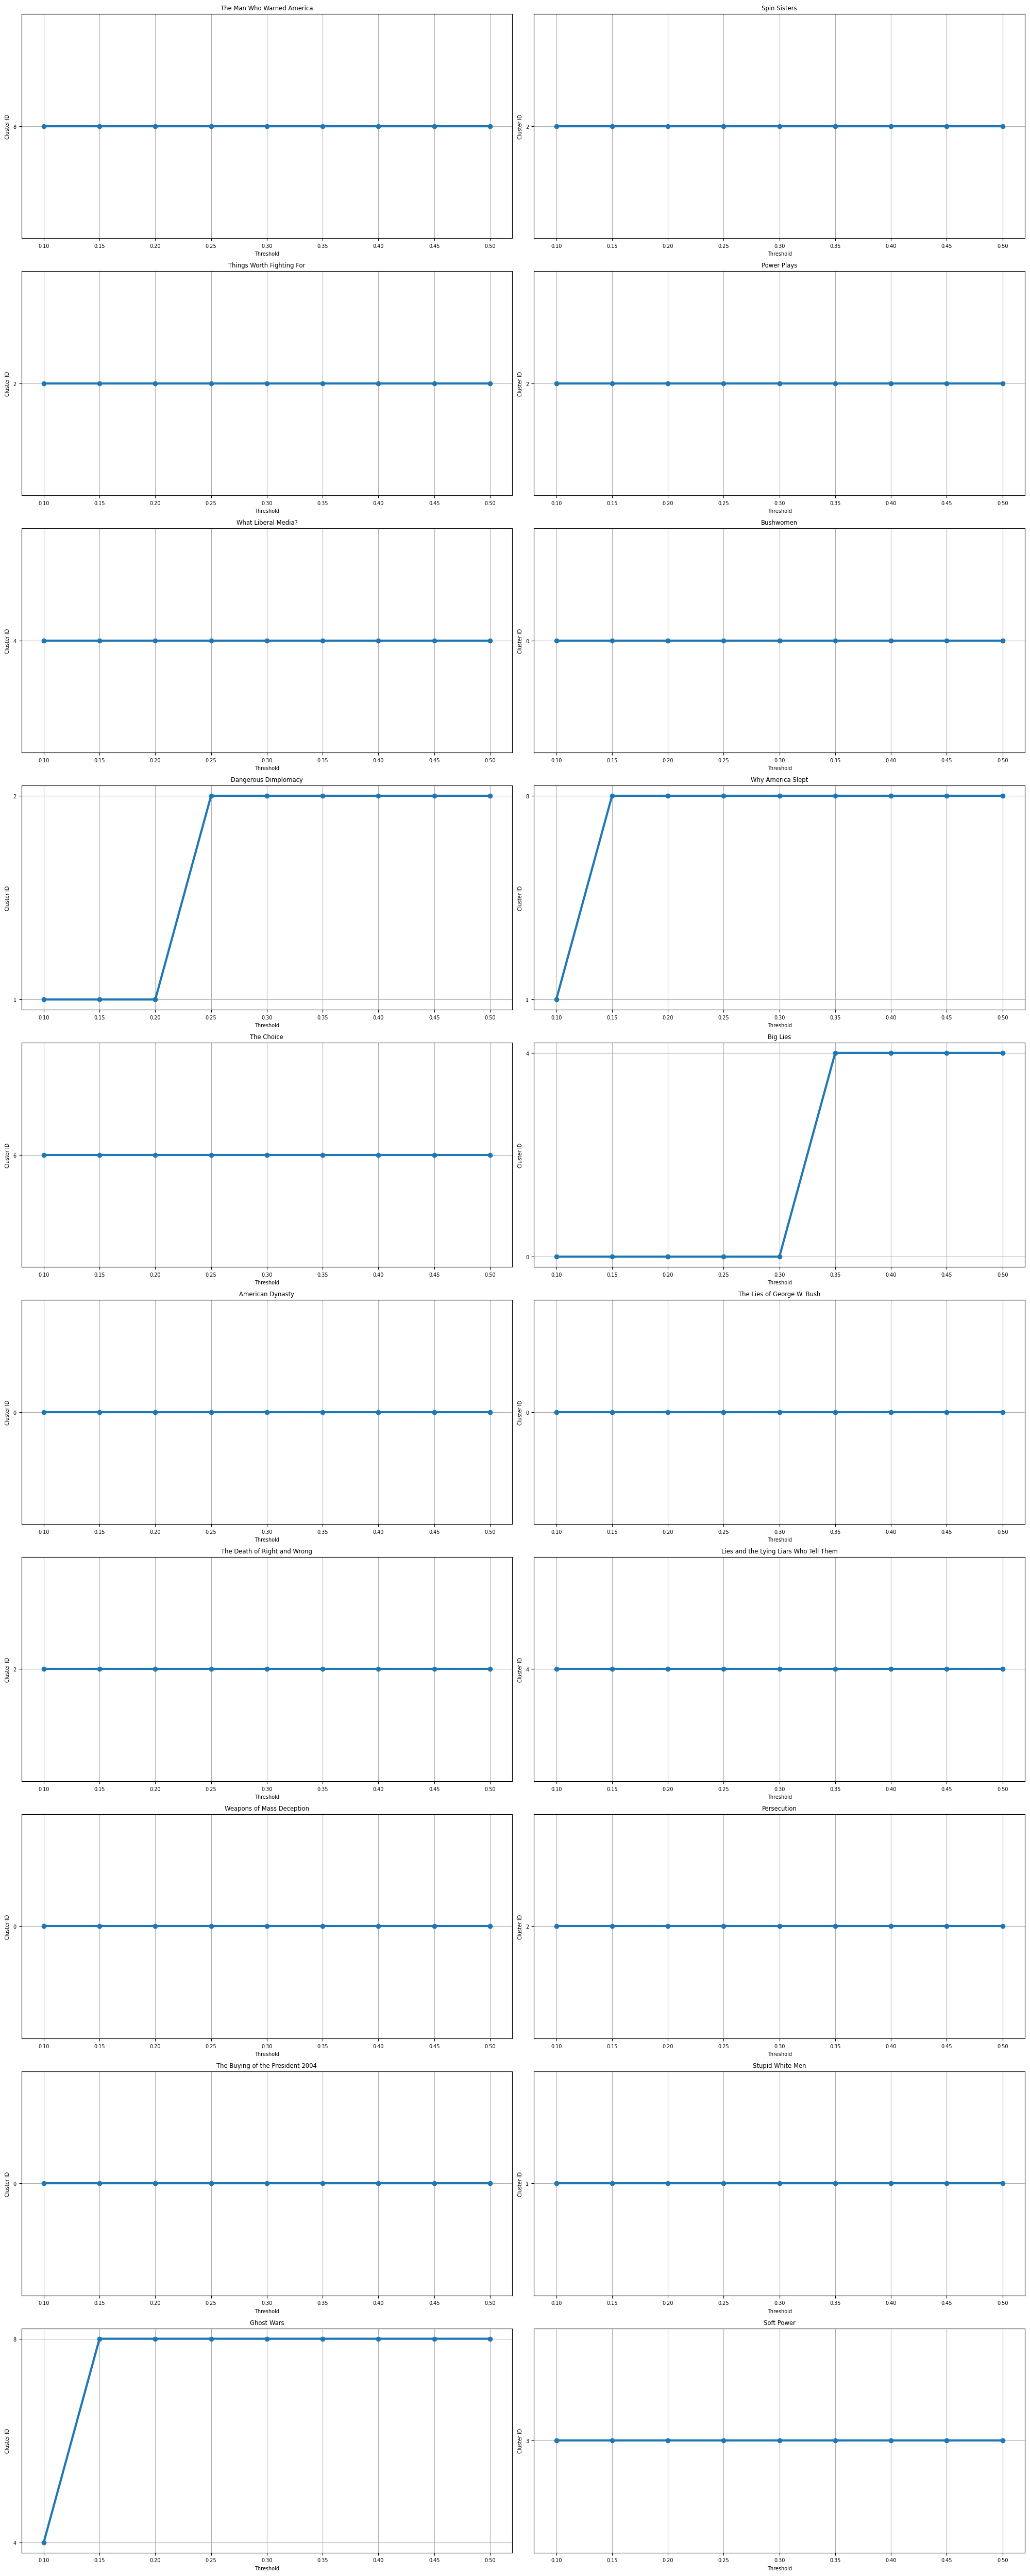

In [145]:
import math
selected_books = list(books)[40:60]  # Adjust this to select different or more books
num_books = len(selected_books)
num_columns = 2  # You can adjust this based on your preference for layout width
num_rows = math.ceil(num_books / num_columns)  # Calculates the number of rows needed

plt.figure(figsize=(10 * num_columns, 5 * num_rows))  # Adjust figure size accordingly

for i, book in enumerate(selected_books, 1):
    plt.subplot(num_rows, num_columns, i)  # Dynamically assign subplot position
    thresholds, cluster_ids = zip(*book_cluster_mapping[book])
    plt.plot(thresholds, cluster_ids, marker='o', linestyle='-')
    plt.title(book)
    plt.xlabel('Threshold')
    plt.ylabel('Cluster ID')
    plt.grid(True)
    plt.xticks(thresholds)
    plt.yticks(sorted(set(cluster_ids)))  # Ensure y-ticks cover all cluster IDs

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

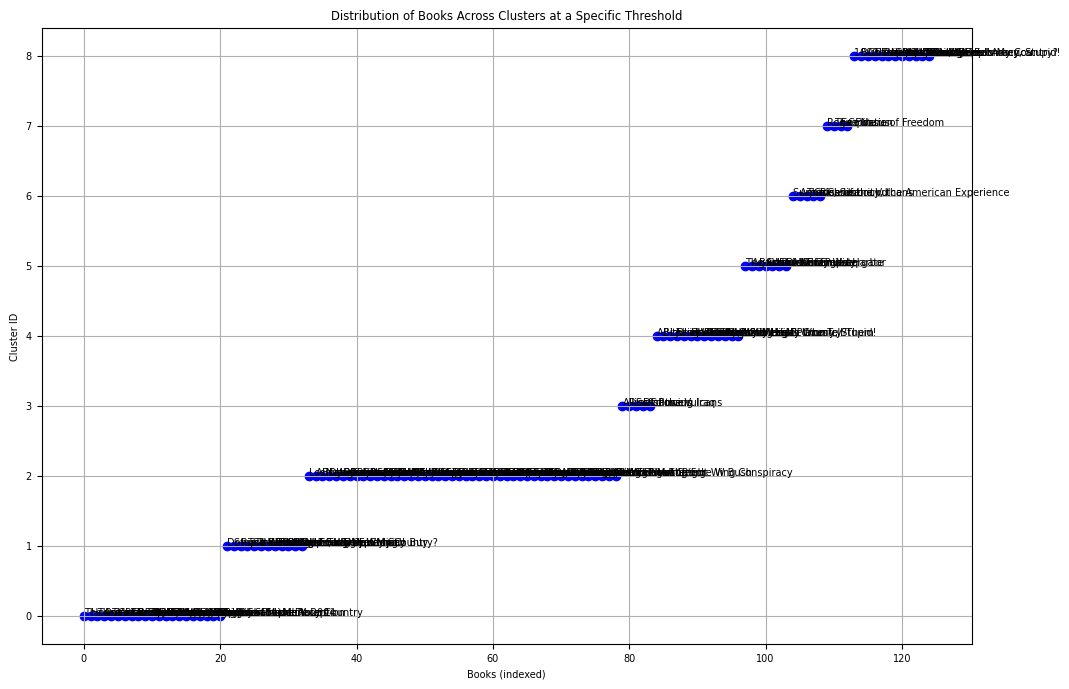

In [147]:
# Path to the JSON file for a specific threshold
file_path = '/Users/ashfak/Downloads/rerequestforcode/list_clusters_polbooks/9_redundancy_ae_0.15.json'

# Load the JSON data
with open(file_path, 'r') as file:
    clusters = json.load(file)

# Prepare data for plotting
book_titles = []
cluster_ids = []
for cluster_id, cluster in enumerate(clusters):
    for book in cluster:
        book_titles.append(book)
        cluster_ids.append(cluster_id)

# Create indices for x-axis placement
x_pos = np.arange(len(book_titles))

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(x_pos, cluster_ids, color='blue')

# Label each point with the book title for clarity (optional, can be cluttered if too many books)
for i, txt in enumerate(book_titles):
    plt.annotate(txt, (x_pos[i], cluster_ids[i]))

plt.xlabel('Books (indexed)')
plt.ylabel('Cluster ID')
plt.title('Distribution of Books Across Clusters at a Specific Threshold')
plt.yticks(np.unique(cluster_ids))  # Ensure y-ticks cover all cluster IDs
plt.grid(True)
plt.show()